#### Implementing FNN from Scratch for a Regression task on sklearn dataset.
        No of Hidden layers = 4
        No of Hidden Units = 20
        No of features = 5
        No of epochs = 1000
        Mini-batch size = 32 (if using mini batch S-Gradient descent)
        Learning Algorithm = Gradient descent with backpropagation (Initial try)
        Loss function = sum of squares fxn (Output Activation = Linear) ---> Regression
        Loss function = cross-entropy (Output Actiavation = softmax) ----> Classification
        Using Sigmoid(logistic function) for activation in between layers for classification
        Using Relu for activation in between layers for regression

Imports 

In [58]:
import tensorflow as tf
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Dataset

In [59]:
X, y = make_regression(n_samples=1000, n_features=5, noise=0.1)
y = y.reshape(-1, 1)  # Reshape y to be a column vector for tensorflow compatibility
# """Alternate way"""
# from sklearn.datasets import fetch_california_housing
# data = fetch_california_housing()
# X = data.data[:, :5]  # Select first 5 features for simpicity(no GPU)
# y = data.target.reshape(-1, 1)

Split the Data

In [60]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # 30 for test 70 for train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 15 for val 15 for test

Standardizing the features(common step)

In [61]:
# Normalize target values
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

Defining the Model 
4 hidden layers, each 20 nodes, activation fxn = Relu(for Regression),Sigmoid(for Classification), Output layer activation fxn = linear, error fxn = MSE 

In [62]:
# Updated model with initializer
class FeedForwardNN(tf.keras.Model):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.hidden2 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.hidden3 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.hidden4 = tf.keras.layers.Dense(20, activation='relu', 
                                             kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        return self.output_layer(x)

From hereon instead of using the standard tf library opt's, writing the own types of Opt for better understanding along with thier drawbacks and why we need improvement

In [63]:
import numpy as np
import tensorflow as tf

class Optimizers:
    def __init__(self, method='vanilla', learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-7, decay_rate=0.9,batch_size=None):
        self.method = method
        self.learning_rate = learning_rate
        self.beta1 = beta1  # Momentum parameter for momentum-based optimizers
        self.beta2 = beta2  # RMSProp/Adam parameter
        self.epsilon = epsilon
        self.decay_rate = decay_rate  # For exponential decay in RMSProp
        self.momentum = None
        self.velocity = None
        self.squared_gradients = None
        self.batch_size = batch_size # For mini-batch optimization
        self.t = 0  # Time step for Adam

    def apply_gradients(self, weights, gradients):
        if self.method == 'vanilla':
            # Vanilla Gradient Descent
            for w, g in zip(weights, gradients):
                w.assign_sub(self.learning_rate * g)

        elif self.method == 'mini_batch': ## **** Doubt
        # Mini-Batch Gradient Descent: Subset of dataset
            if self.batch_size is None:
                raise ValueError("Batch size must be specified for mini-batch optimization.")
            for w, g in zip(weights, gradients):
                w.assign_sub(self.learning_rate * g / self.batch_size)  # Averaging gradients for the mini-batch
        
        elif self.method == 'sgd':
            # Stochastic Gradient Descent: Single sample
            for w, g in zip(weights, gradients):
                w.assign_sub(self.learning_rate * g)

        elif self.method == 'momentum':
            # Momentum
            if self.momentum is None:
                self.momentum = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * g
                w.assign_sub(self.learning_rate * self.momentum[i])

        elif self.method == 'nesterov':
            # Nesterov Accelerated Gradient (NAG)
            if self.momentum is None:
                self.momentum = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                prev_momentum = self.momentum[i]
                self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * g
                w.assign_sub(self.learning_rate * (self.beta1 * prev_momentum + (1 - self.beta1) * g))

        elif self.method == 'adagrad':
            # Adagrad
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.squared_gradients[i] += tf.square(g)
                adjusted_lr = self.learning_rate / (tf.sqrt(self.squared_gradients[i]) + self.epsilon)
                w.assign_sub(adjusted_lr * g)

        elif self.method == 'rmsprop':
            # RMSProp
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.squared_gradients[i] = self.decay_rate * self.squared_gradients[i] + (1 - self.decay_rate) * tf.square(g)
                adjusted_lr = self.learning_rate / (tf.sqrt(self.squared_gradients[i]) + self.epsilon)
                w.assign_sub(adjusted_lr * g)

        elif self.method == 'adadelta':
            # Adadelta
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            if self.velocity is None:
                self.velocity = [tf.zeros_like(w) for w in weights]
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.squared_gradients[i] = self.decay_rate * self.squared_gradients[i] + (1 - self.decay_rate) * tf.square(g)
                update = tf.sqrt(self.velocity[i] + self.epsilon) / (tf.sqrt(self.squared_gradients[i]) + self.epsilon) * g
                self.velocity[i] = self.decay_rate * self.velocity[i] + (1 - self.decay_rate) * tf.square(update)
                w.assign_sub(update)

        elif self.method == 'adam':
            # Adam
            if self.momentum is None:
                self.momentum = [tf.zeros_like(w) for w in weights]
            if self.squared_gradients is None:
                self.squared_gradients = [tf.zeros_like(w) for w in weights]
            self.t += 1
            for i, (w, g) in enumerate(zip(weights, gradients)):
                self.momentum[i] = self.beta1 * self.momentum[i] + (1 - self.beta1) * g
                self.squared_gradients[i] = self.beta2 * self.squared_gradients[i] + (1 - self.beta2) * tf.square(g)
                m_hat = self.momentum[i] / (1 - tf.pow(self.beta1, self.t))
                v_hat = self.squared_gradients[i] / (1 - tf.pow(self.beta2, self.t))
                w.assign_sub(self.learning_rate * m_hat / (tf.sqrt(v_hat) + self.epsilon))

        else:
            raise ValueError(f"Unknown optimization method: {self.method}")


Loss Function = MSE

In [64]:
mse_loss = tf.keras.losses.MeanSquaredError()

Training the model with custom Opt defined above

In [65]:
epochs = 1000
train_losses, val_losses, test_losses = [], [], []

# Initialize the model
model = FeedForwardNN()
# batch_size = 32 # For mini-batch optimization
# Initialize the optimizer
optimizer = Optimizers(method='adam', learning_rate=0.01)  # Replace 'adam' with your desired method

for epoch in range(epochs):
    # Training step
    with tf.GradientTape() as tape:
        predictions = model(X_train)
        train_loss = mse_loss(y_train, predictions)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    optimizer.apply_gradients(model.trainable_variables, gradients)
    val_predictions = model(X_val) #validation step
    val_loss = mse_loss(y_val, val_predictions)

    test_predictions = model(X_test)
    test_loss = mse_loss(y_test, test_predictions)

    train_losses.append(train_loss.numpy())
    val_losses.append(val_loss.numpy())
    test_losses.append(test_loss.numpy())
    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss.numpy():.4f}, Val Loss = {val_loss.numpy():.4f}, Test Loss = {test_loss.numpy():.4f}")

Epoch 25: Train Loss = 0.0172, Val Loss = 0.0213, Test Loss = 0.0234
Epoch 50: Train Loss = 0.0031, Val Loss = 0.0034, Test Loss = 0.0050
Epoch 75: Train Loss = 0.0017, Val Loss = 0.0023, Test Loss = 0.0034
Epoch 100: Train Loss = 0.0012, Val Loss = 0.0017, Test Loss = 0.0027
Epoch 125: Train Loss = 0.0009, Val Loss = 0.0015, Test Loss = 0.0023
Epoch 150: Train Loss = 0.0017, Val Loss = 0.0014, Test Loss = 0.0021
Epoch 175: Train Loss = 0.0007, Val Loss = 0.0012, Test Loss = 0.0017
Epoch 200: Train Loss = 0.0006, Val Loss = 0.0011, Test Loss = 0.0015
Epoch 225: Train Loss = 0.0005, Val Loss = 0.0010, Test Loss = 0.0013
Epoch 250: Train Loss = 0.0015, Val Loss = 0.0009, Test Loss = 0.0012
Epoch 275: Train Loss = 0.0004, Val Loss = 0.0008, Test Loss = 0.0011
Epoch 300: Train Loss = 0.0003, Val Loss = 0.0008, Test Loss = 0.0010
Epoch 325: Train Loss = 0.0003, Val Loss = 0.0007, Test Loss = 0.0009
Epoch 350: Train Loss = 0.0002, Val Loss = 0.0006, Test Loss = 0.0008
Epoch 375: Train Loss =

Evaluate

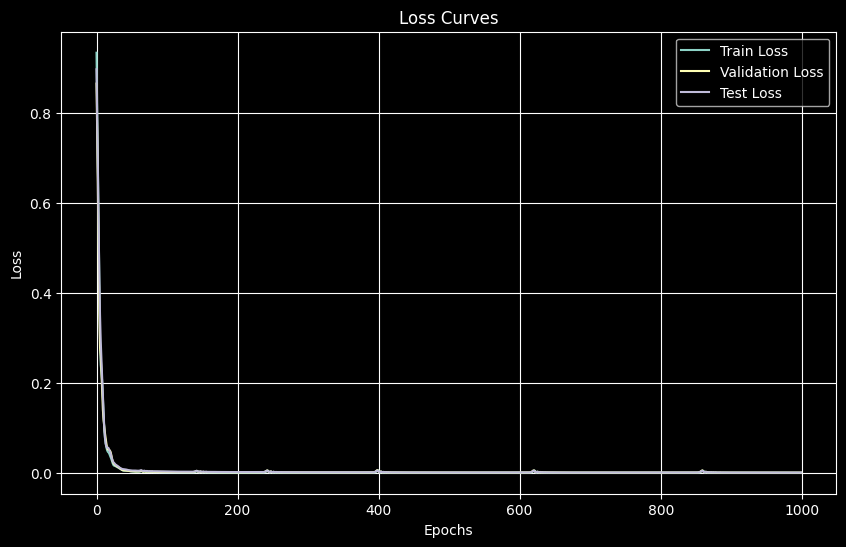

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()